In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter


1. Data Cleaning and Processing

1.1 Data Validity Check

,media_type,blank_drift_slope_per_hr,blank_range
0,YPD,-0.000076,0.0050
1,YPDG,-0.000126,0.0075
2,YPG,-0.000109,0.0075


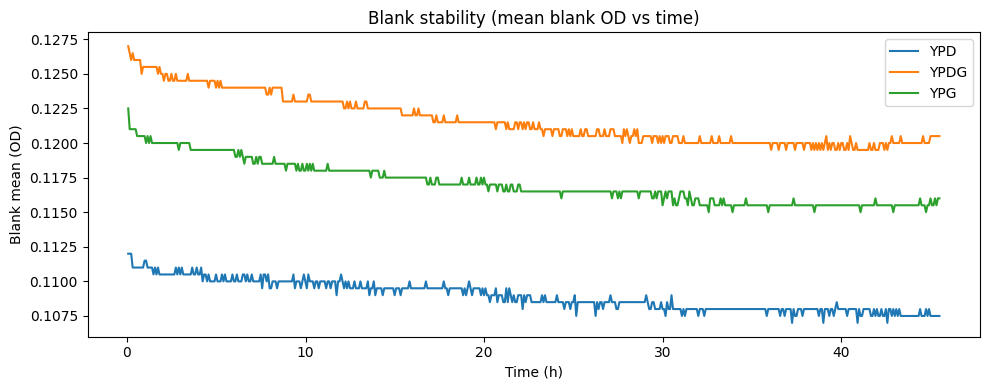

,well,min_OD,max_abs_jump,flag_negative,flag_jump
39,D12,0.125,0.069,False,True
95,H9,0.127,0.078,False,True


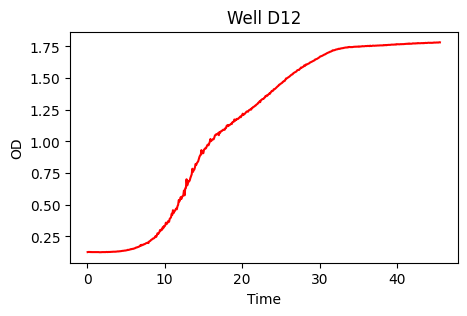

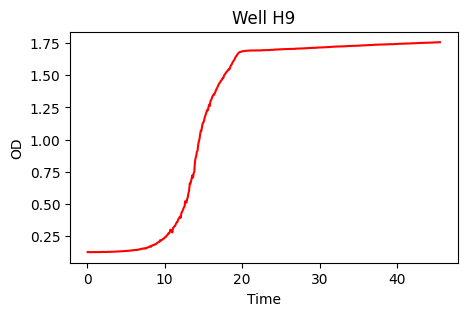

In [20]:
# Load the dataset
absorb = pd.read_csv("abs.csv")
absorb.head()

cat = pd.read_csv("cat.csv")
cat.head()

gain_70 = pd.read_csv("gain_70.csv")
gain_70.head()  

new_rows = absorb.columns[2:-3]
df = pd.DataFrame()
df["well"]=new_rows

# Correcting the absorbance data
absorb["Time"] = pd.to_timedelta(absorb["Time"]).dt.total_seconds()/3600
well_cols = absorb.columns[absorb.columns.str.match(r"^[A-H](?:[1-9]|1[0-2])$")]
abs_long = absorb[["Time", *well_cols]].melt(id_vars="Time", var_name="well", value_name="OD")
abs_long = abs_long.merge(cat[["well", "media_type", "function"]], on="well", how="left")

# Blank Check (if they drifts over time)
blank_only = abs_long[abs_long["well"].isin(abs_long[abs_long["function"].str.lower().eq("blank")]["well"].unique())].copy()

blank_curve = (blank_only
              .groupby(["media_type","Time"], as_index=False)["OD"]
              .mean()
              .rename(columns={"OD":"blank_mean"}))

# slope per media type
def slope(x, y):
    x = np.asarray(x); y = np.asarray(y)
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 2: return np.nan
    return np.polyfit(x[m], y[m], 1)[0]

blank_stats = (blank_curve.groupby("media_type")
              .apply(lambda g: pd.Series({
                  "blank_drift_slope_per_hr": slope(g["Time"], g["blank_mean"]),
                  "blank_range": g["blank_mean"].max() - g["blank_mean"].min()
              }))
              .reset_index())

display(blank_stats)

# plot blank means
plt.figure(figsize=(10,4))
for mt, g in blank_curve.groupby("media_type"):
    plt.plot(g["Time"], g["blank_mean"], label=mt)
plt.xlabel("Time (h)"); plt.ylabel("Blank mean (OD)")
plt.title("Blank stability (mean blank OD vs time)")
plt.legend()
plt.tight_layout()
plt.show()

# Flag bad wells (negative or large jumps)
abs_long = abs_long.sort_values(["well","Time"])
abs_long["dOD"] = abs_long.groupby("well")["OD"].diff()

bad = abs_long.groupby("well").apply(lambda g: pd.Series({
    "min_OD": g["OD"].min(),
    "max_abs_jump": g["dOD"].abs().max()
})).reset_index()

bad["flag_negative"] = bad["min_OD"] < -0.01

median = bad["max_abs_jump"].median()
mad = np.median(np.abs(bad["max_abs_jump"] - median))

bad["flag_jump"] = bad["max_abs_jump"] > median + 6 * mad

display(bad[bad["flag_negative"] | bad["flag_jump"]])

flagged_wells = bad.loc[bad["flag_negative"] | bad["flag_jump"], "well"]

for w in flagged_wells:
    g = abs_long[abs_long["well"] == w]
    plt.figure(figsize=(5,3))
    plt.plot(g["Time"], g["OD"], 'r')
    plt.title(f"Well {w}")
    plt.xlabel("Time")
    plt.ylabel("OD")
    plt.show()



Blank stability plot

The blank wells show a small, monotonic decrease in OD over time (≈0.005–0.008 OD across ~45 h) with no oscillations or sudden shifts. The magnitude of this drift is negligible compared to biological growth signals (from 0.12 to 1.75 in D12 and H9), indicating the plate reader measurements are stable and early OD differences primarily reflect biological activity rather than instrumental artifacts.

Flagged Well Check

The examined flagged wells (D12 and H9) both display smooth, sigmoidal growth trajectories characterized by a lag phase, continuous exponential increase, and stable saturation without abrupt discontinuities. Although the automatic quality check identified large changes in slope, these changes correspond to natural biological acceleration during exponential growth rather than measurement artifacts. Therefore, the flagged behavior reflects genuine cell growth dynamics, and both wells are retained for subsequent analysis.

1.2 Data Correction

In [ ]:
# Baseline correction for instrumental noise:
abs_long = abs_long.sort_values(["well", "Time"])
abs_long["OD_basecorr"] = abs_long["OD"] - abs_long.groupby("well")["OD"].transform("first")

# Blank subtraction 

blank_ref = (
    abs_long[abs_long["function"]=="blank"]
    .groupby(["media_type", "Time"], as_index=False)["OD"]
    .mean()
    .rename(columns={"OD": "OD_blank"})
)

abs_long = abs_long.merge(blank_ref, on=["media_type", "Time"], how="left")
abs_long["OD"] = abs_long["OD"] - abs_long["OD_blank"]



# Smoothing (Savitzky-Golay per well)
def smooth_group(g):
    g = g.sort_values("Time").copy()
    y = g["OD"].values

    # choose valid window size automatically
    n = len(y)
    if n < 5:
        g["OD_smooth"] = y
        return g

    window = min(11, n if n % 2 == 1 else n-1)
    window = max(window, 5)  # minimum usable
    
    try:
        g["OD_smooth"] = savgol_filter(y, window_length=window, polyorder=3)
    except:
        g["OD_smooth"] = y
        
    return g

# Bad rows with missing OD (should not be many if any)
abs_long = abs_long.dropna(subset=["OD"])

# Smooth while keeping columns
abs_long = (
    abs_long
    .sort_values(["well", "Time"])
    .groupby("well")
    .apply(smooth_group)
    .reset_index()
)
abs_long = abs_long.drop(columns=["level_1"], errors="ignore")

print(abs_long.head())

# double check with Lily because there should not be NaN showing for any well


#Compare raw corrected vs smoothed for a quick check
plt.figure(figsize=(12, 6))
for _, g in abs_long.groupby("well"):
    plt.plot(g["Time"], g["OD"],"g-", alpha=0.12, lw=1)
plt.xlabel("Time (h)")
plt.ylabel("OD")
plt.title("Unsmoothed OD (Green)")
plt.show()

plt.figure(figsize=(12, 6))
for _, g in abs_long.groupby("well"):
    plt.plot(g["Time"], g["OD_smooth"], "r-", alpha=0.08, lw=1)
plt.xlabel("Time (h)")
plt.ylabel("OD")
plt.title("Smoothed OD (Red)")
plt.show()

# Simple numeric noise check (median std of first differences)
noise_raw = abs_long.groupby("well")["OD"].apply(lambda s: np.nanstd(np.diff(s)))
noise_smooth = abs_long.groupby("well")["OD_smooth"].apply(lambda s: np.nanstd(np.diff(s)))
print("Median noise raw   :", float(np.nanmedian(noise_raw)))
print("Median noise smooth:", float(np.nanmedian(noise_smooth)))
print("Noise reduction %  :", float(100*(1 - np.nanmedian(noise_smooth)/np.nanmedian(noise_raw))))




1.3 Computing features and merge

In [13]:
'''
OD_init: Initial optical density (OD) measurement at time 0 at 600nm
OD_1h: OD measurement at 1 hour (lag phase)
OD_2h: OD measurement at 2 hours (lag phase)
OD_3h: OD measurement at 3 hours (early log phase)
OD_4h: OD measurement at 4 hours (early log phase)
growth_rate: Slope of the OD curve at 4 hours modelled with log scale
lag: Duration of the lag phase (time until OD starts to increase)
AUC_4h: Area under the OD curve from 0 to 4 hours
curvature_4h: Curvature of the OD curve at 4 hours : slope of (0-2)hours - slope of (2-4)hours
'''
# Merge medita_type, OD_init
df_merged = df.merge(cat[['well',"OD_init","media_type","function"]], on='well', how='left')

# Merge OD_1h, OD_2h, OD_3h, OD_4h from the smoothed data
targets = [1.0,2.0, 3.0, 4.0]
parts = []

for t in targets:
    tmp = abs_long.dropna(subset=["OD_smooth"]).copy()
    idx = tmp.assign(diff=(tmp["Time"] - t).abs()).groupby("well")["diff"].idxmin()
    out = tmp.loc[idx, ["well", "OD_smooth"]].rename(columns={"OD_smooth": f"OD_{int(t)}h"})
    parts.append(out)

od_multi = parts[0]
for p in parts[1:]:
    od_multi = od_multi.merge(p, on="well", how="outer")
df_merged["well"] = df_merged["well"].astype(str).str.strip().str.upper()
od_multi["well"] = od_multi["well"].astype(str).str.strip().str.upper()

df_merged = df_merged.merge(od_multi, on="well", how="left")


# Merge specific growth rate
def calc_mu(g):
    x = g["Time"]
    y = g["OD_smooth"]
    # exponential region
    exp = (y > 0.01) & (y < 0.2) & x.notna() & y.notna()

    if exp.sum() < 5:
        return np.nan

    return np.polyfit(x[exp], np.log(y[exp]), 1)[0]

mu = (
    abs_long.groupby("well")
        .apply(calc_mu)
        .reset_index(name="specific_growth_rate")
)

df_merged = df_merged.merge(mu, on="well", how="left")

# Merge lag time period
def compute_lag(df):
    # Keep only valid rows and sort by time
    g = df[["Time", "OD_smooth"]].copy()
    g["Time"] = pd.to_numeric(g["Time"], errors="coerce")
    g["OD_smooth"] = pd.to_numeric(g["OD_smooth"], errors="coerce")
    g = g.dropna().sort_values("Time")

    # Ignore non-positive OD
    g = g[g["OD_smooth"] > 0].copy()
    if len(g) < 3:
        return pd.Series({"lag_time": np.nan})

    # Derivative from consecutive points: dOD/dt
    dt = g["Time"].diff()
    dOD = g["OD_smooth"].diff()
    g["slope"] = dOD / dt

    # Invalid derivative points
    g.loc[dt <= 0, "slope"] = np.nan

    # Rolling mean slope (~30 min)
    g["slope_roll"] = g["slope"].rolling(
        window=9, min_periods=3
    ).mean()

    # Above-threshold condition
    above = g["slope_roll"] > 0.002

    # Require persistence: >=2 consecutive windows above threshold
    persistent = above & above.shift(1, fill_value=False)

    if not persistent.any():
        return pd.Series({"lag_time": np.nan})

    lag_time = g.loc[persistent, "Time"].iloc[0]
    return pd.Series({"lag_time": lag_time})

# Apply per well
lag_df = abs_long.groupby("well", group_keys=False).apply(compute_lag).reset_index()
df_merged = df_merged.merge(lag_df, on="well", how="left")
# lag_df columns: well, lag_time

# Merge AUC_4h
import numpy as np

def compute_auc_4h(g):

    g = g.sort_values("Time")

    # keep 0–4 hr window
    g = g[(g["Time"] >= 0) & (g["Time"] <= 4)]

    if len(g) < 3:
        return np.nan

    t = g["Time"].to_numpy()
    y = g["OD_smooth"].to_numpy()

    # remove invalid values
    valid = (~np.isnan(t)) & (~np.isnan(y))
    t = t[valid]
    y = y[valid]

    if len(t) < 3:
        return np.nan

    return np.trapezoid(y, t)

auc_df = (
    abs_long.groupby("well")
    .apply(compute_auc_4h)
    .reset_index(name="AUC_4h")
)

df_merged = df_merged.merge(auc_df, on="well", how="left")

# Merge curvature_4h
def curvature_slope_diff(g):
    g = g.sort_values("Time")
    y = g["OD_smooth"]
    x = g["Time"]

    def slope_in_window(t0, t1):
        w = (x >= t0) & (x <= t1) & x.notna() & y.notna()
        if w.sum() < 3:
            return np.nan
        return np.polyfit(x[w].to_numpy(), y[w].to_numpy(), 1)[0]  # OD/hr

    m01 = slope_in_window(0, 2)
    m24 = slope_in_window(2, 4)

    if np.isfinite(m01) and np.isfinite(m24):
        return m24 - m01
    return np.nan
curv_df = (
    abs_long.groupby("well")
    .apply(curvature_slope_diff)
    .reset_index(name="curvature_4h")
)
df_merged = df_merged.merge(curv_df, on="well", how="left")
df_merged.head()





,well,OD_init,media_type,function,OD_1h,OD_2h,OD_3h,OD_4h,specific_growth_rate,lag_time,AUC_4h,curvature_4h
0,A1,0.62500,YPG,trial_2,0.002483,0.008519,0.018652,0.038436,0.559191,0.985278,0.047097,0.010868
1,A2,NaN,YPDG,blank,-0.000400,-0.000575,-0.000509,-0.000500,NaN,NaN,-0.001818,0.000345
2,A3,0.15625,YPG,trial_3,0.002289,0.004339,0.007749,0.015897,0.552235,0.401944,0.022182,0.004361
3,A4,0.15625,YPDG,trial_1,0.002873,0.006311,0.012211,0.023619,0.566806,0.401944,0.032320,0.005718
4,A5,0.31250,YPG,trial_3,0.002797,0.006181,0.013619,0.027497,0.577195,0.401944,0.035000,0.008044


1.3 Compute Outcome and merge

In [22]:
'''outcome: final fluorescence /final OD (protein/cell) at ~45 hrs'''
# ---------- A) Wide fluorescence -> long ----------
# gain_70 wide format: Time + well columns (A1..H12)
well_cols = gain_70.columns[gain_70.columns.str.match(r"^[A-H](?:[1-9]|1[0-2])$")]

fl_long = gain_70[["Time", *well_cols]].melt(
    id_vars="Time", var_name="well", value_name="FL"
)
fl_long["Time"] = pd.to_timedelta(fl_long["Time"], errors="coerce").dt.total_seconds() / 3600

# attach metadata for blank correction
fl_long = fl_long.merge(cat[["well", "media_type", "function"]], on="well", how="left")

# ---------- B) fluorescence baseline + blank correction ----------
fl = fl_long.copy()
fl["FL"] = pd.to_numeric(fl["FL"], errors="coerce")

i0 = fl.groupby("well")["Time"].idxmin()
fl0 = fl.loc[i0, ["well", "FL"]].rename(columns={"FL": "FL_t0"})
fl = fl.merge(fl0, on="well", how="left")
fl["FL_base"] = fl["FL"] - fl["FL_t0"]

blank_ref = (
    fl[fl["function"].str.lower().eq("blank")]
    .groupby(["media_type", "Time"], as_index=False)["FL_base"]
    .mean()
    .rename(columns={"FL_base": "FL_blank"})
)

fl = fl.merge(blank_ref, on=["media_type", "Time"], how="left")
fl["FL_corr"] = fl["FL_base"] - fl["FL_blank"]

# ---------- C) align to OD end time (earlier stop between FL and OD) ----------
od = abs_long.copy()
od_col = next(c for c in ["OD_smooth", "OD_bs", "OD"] if c in od.columns)
od["Time"] = pd.to_numeric(od["Time"], errors="coerce")
od[od_col] = pd.to_numeric(od[od_col], errors="coerce")

end_times = (
    fl.groupby("well", as_index=False)["Time"].max().rename(columns={"Time": "fl_end"})
    .merge(
        od.groupby("well", as_index=False)["Time"].max().rename(columns={"Time": "od_end"}),
        on="well",
        how="inner",
    )
)
end_times["t_end"] = end_times[["fl_end", "od_end"]].min(axis=1)

# last fluorescence at/before t_end
fl_pick = fl.merge(end_times[["well", "t_end"]], on="well", how="inner")
fl_pick = fl_pick[fl_pick["Time"] <= fl_pick["t_end"]]
idx_fl = fl_pick.groupby("well")["Time"].idxmax()
fl_final = fl_pick.loc[idx_fl, ["well", "FL_corr"]].rename(columns={"FL_corr": "final_fluor_corr"})

# last OD at/before t_end
od_pick = od.merge(end_times[["well", "t_end"]], on="well", how="inner")
od_pick = od_pick[od_pick["Time"] <= od_pick["t_end"]]
idx_od = od_pick.groupby("well")["Time"].idxmax()
od_final = od_pick.loc[idx_od, ["well", od_col]].rename(columns={od_col: "final_OD"})

# ---------- D) final outcome ----------
final_df = (
    end_times[["well", "t_end"]]
    .merge(fl_final, on="well", how="left")
    .merge(od_final, on="well", how="left")
)
final_df["outcome"] = np.where(
    final_df["final_OD"] > 0,
    final_df["final_fluor_corr"] / final_df["final_OD"],
    np.nan
)

df_merged["outcome"] = df_merged["well"].map(final_df.set_index("well")["outcome"])
df_merged.head()






,well,OD_init,media_type,function,OD_1h,OD_2h,OD_3h,OD_4h,specific_growth_rate,lag_time,AUC_4h,curvature_4h,outcome
0,A1,0.62500,YPG,trial_2,0.002483,0.008519,0.018652,0.038436,0.559191,0.985278,0.047097,0.010868,14373.111782
1,A2,NaN,YPDG,blank,-0.000400,-0.000575,-0.000509,-0.000500,NaN,NaN,-0.001818,0.000345,50.420168
2,A3,0.15625,YPG,trial_3,0.002289,0.004339,0.007749,0.015897,0.552235,0.401944,0.022182,0.004361,12526.422764
3,A4,0.15625,YPDG,trial_1,0.002873,0.006311,0.012211,0.023619,0.566806,0.401944,0.032320,0.005718,1368.932039
4,A5,0.31250,YPG,trial_3,0.002797,0.006181,0.013619,0.027497,0.577195,0.401944,0.035000,0.008044,13421.794135


1.4 Predictability Check

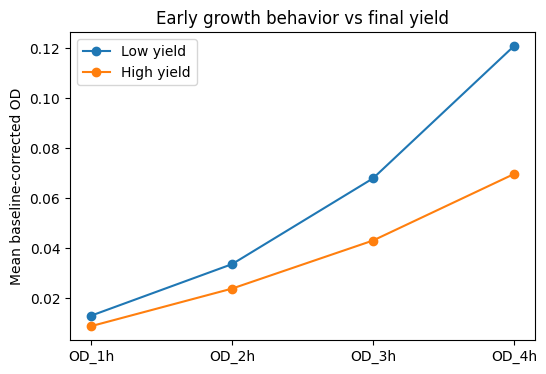

In [23]:
# Find value where 70% of wells are below (top 30% as "high yield")
threshold = df_merged["outcome"].quantile(0.7)
df_merged["high_yield"] = (df_merged["outcome"] >= threshold).astype(int)
# remove blanks
df_merged = df_merged[df_merged["function"].str.contains("trial", na=False)]
early_cols = ["OD_1h","OD_2h","OD_3h","OD_4h"]
avg = df_merged.groupby("high_yield")[early_cols].mean().T
plt.figure(figsize=(6,4))
plt.plot(avg.index, avg[0], marker="o", label="Low yield")
plt.plot(avg.index, avg[1], marker="o", label="High yield")

plt.ylabel("Mean baseline-corrected OD")
plt.title("Early growth behavior vs final yield")
plt.legend()
plt.show()



In the first few hours, the cultures that eventually make a lot of product actually grow more slowly, while the ones that grow quickly early on end up producing less. This suggests the cells are “choosing” where to spend their energy — either dividing and growing fast, or making the protein. Because this difference appears very early, we can use early growth behavior to predict later success.